# Classification and Clustering
Détection d'intrusion à partir du dataset NSL-KDD, dérivé du dataset [KDD99](http://kdd.ics.uci.edu/databases/kddcup99/kddcup99.html). [Description complète du challenge original (1999)](http://kdd.ics.uci.edu/databases/kddcup99/task.html).

> The competition task was to build a network intrusion detector, a predictive model capable of distinguishing between "bad" connections, called intrusions or attacks, and "good" normal connections. This database contains a standard set of data to be audited, which includes a wide variety of intrusions simulated in a military network environment.




Quatre catégories d'attaques dans ce dataset (cf [taxonomy](http://kdd.ics.uci.edu/databases/kddcup99/training_attack_types)) :
> - **DOS**: denial-of-service, e.g. syn flood;
> - **R2L**: unauthorized access from a remote machine, e.g. guessing password;
> - **U2R**:  unauthorized access to local superuser (root) privileges, e.g., various buffer overflow attacks;
> - **probing**: surveillance and other probing, e.g., port scanning.

Catégorie | Attaques
--- | --- 
dos | back,land,neptune,pod,smurf,teardrop
probe | ipsweep,nmap,portsweep,satan
r2l | ftp_write,guess_passwd,imap,multihop,phf,spy,warezclient,warezmaster
u2r | buffer_overflow,loadmodule,perl,rootkit

## Objectifs pédagogiques
- [**done**] loader et préparer les données
- classification avec Random Forest, Naive Bayes
- clustering avec K-means, DBSCAN
- évaluation de la classification avec des performance metrics
- évaluation du clustering naive en utilisant les catégories d'attaque
- évaluation du clustering avec des performance metrics
- *(optionel) visualisation avec t-SNE*
- *(optionel) clustering avec d'autres techniques*

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn
import os

# Data

## Load dataset

In [2]:
dataset_path = os.path.join('.', 'dataset')
train20_path = os.path.join(dataset_path, 'KDDTrain+_20Percent.txt')
train_path = os.path.join(dataset_path, 'KDDTrain+.txt')
test_path = os.path.join(dataset_path, 'KDDTest+.txt')

In [3]:
col_names = np.array(["duration","protocol_type","service","flag","src_bytes",
    "dst_bytes","land","wrong_fragment","urgent","hot","num_failed_logins",
    "logged_in","num_compromised","root_shell","su_attempted","num_root",
    "num_file_creations","num_shells","num_access_files","num_outbound_cmds",
    "is_host_login","is_guest_login","count","srv_count","serror_rate",
    "srv_serror_rate","rerror_rate","srv_rerror_rate","same_srv_rate",
    "diff_srv_rate","srv_diff_host_rate","dst_host_count","dst_host_srv_count",
    "dst_host_same_srv_rate","dst_host_diff_srv_rate","dst_host_same_src_port_rate",
    "dst_host_srv_diff_host_rate","dst_host_serror_rate","dst_host_srv_serror_rate",
    "dst_host_rerror_rate","dst_host_srv_rerror_rate","labels", "foo"])

In [4]:
attack_types = {
    'normal': 'normal',
    
    'back': 'DoS',
    'land': 'DoS',
    'neptune': 'DoS',
    'pod': 'DoS',
    'smurf': 'DoS',
    'teardrop': 'DoS',
    'mailbomb': 'DoS',
    'apache2': 'DoS',
    'processtable': 'DoS',
    'udpstorm': 'DoS',
    
    'ipsweep': 'Probe',
    'nmap': 'Probe',
    'portsweep': 'Probe',
    'satan': 'Probe',
    'mscan': 'Probe',
    'saint': 'Probe',

    'ftp_write': 'R2L',
    'guess_passwd': 'R2L',
    'imap': 'R2L',
    'multihop': 'R2L',
    'phf': 'R2L',
    'spy': 'R2L',
    'warezclient': 'R2L',
    'warezmaster': 'R2L',
    'sendmail': 'R2L',
    'named': 'R2L',
    'snmpgetattack': 'R2L',
    'snmpguess': 'R2L',
    'xlock': 'R2L',
    'xsnoop': 'R2L',
    'worm': 'R2L',
    
    'buffer_overflow': 'U2R',
    'loadmodule': 'U2R',
    'perl': 'U2R',
    'rootkit': 'U2R',
    'httptunnel': 'U2R',
    'ps': 'U2R',    
    'sqlattack': 'U2R',
    'xterm': 'U2R'
}

In [5]:
categorical_idx = [1, 2, 3]
binary_idx = [6, 11, 13, 14, 20, 21]
numerical_idx = list(set(range(41)).difference(categorical_idx).difference(binary_idx))

categorical_cols = col_names[categorical_idx].tolist()
binary_cols = col_names[binary_idx].tolist()
numerical_cols = col_names[numerical_idx].tolist()

In [6]:
def load_data(data_path):
    df = pd.read_csv(data_path, header=None, index_col=False, names=col_names).drop("foo", axis='columns')
    df['attack_type'] = df.labels.apply(lambda attack: attack_types[attack])
    
    # casting
    df = df.astype({col: 'category' for col in categorical_cols}, copy=False)
    df = df.astype({col: np.float32 for col in numerical_cols}, copy=False)
    
    return df

In [7]:
df_train20 = load_data(train20_path)
df_train = load_data(train_path)
df_test = load_data(test_path)

In [8]:
df_train20.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,labels,attack_type
0,0.0,tcp,ftp_data,SF,491.0,0.0,0,0.0,0.0,0.0,...,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal,normal
1,0.0,udp,other,SF,146.0,0.0,0,0.0,0.0,0.0,...,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal,normal
2,0.0,tcp,private,S0,0.0,0.0,0,0.0,0.0,0.0,...,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,neptune,DoS
3,0.0,tcp,http,SF,232.0,8153.0,0,0.0,0.0,0.0,...,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal,normal
4,0.0,tcp,http,SF,199.0,420.0,0,0.0,0.0,0.0,...,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal,normal


In [9]:
df_train20.describe()

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate
count,25192.000000,2.519200e+04,2.519200e+04,25192.000000,25192.000000,25192.00000,25192.000000,25192.000000,25192.000000,25192.000000,...,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000
mean,305.054108,2.433063e+04,3.491847e+03,0.000079,0.023738,0.00004,0.198039,0.001191,0.394768,0.227850,...,182.532074,115.063034,0.519791,0.082539,0.147453,0.031844,0.285800,0.279846,0.117800,0.118769
std,2686.555664,2.410806e+06,8.883071e+04,0.008910,0.260221,0.00630,2.154202,0.045418,0.488811,10.417352,...,98.993896,110.646851,0.448944,0.187191,0.308367,0.110575,0.445316,0.446075,0.305869,0.317333
min,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,...,84.000000,10.000000,0.050000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,4.400000e+01,0.000000e+00,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,...,255.000000,61.000000,0.510000,0.030000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,2.790000e+02,5.302500e+02,0.000000,0.000000,0.00000,0.000000,0.000000,1.000000,0.000000,...,255.000000,255.000000,1.000000,0.070000,0.060000,0.020000,1.000000,1.000000,0.000000,0.000000
max,42862.000000,3.817091e+08,5.151385e+06,1.000000,3.000000,1.00000,77.000000,4.000000,1.000000,884.000000,...,255.000000,255.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


# Separation label / données

In [10]:
var_names = np.array(["duration","protocol_type","service","flag","src_bytes",
    "dst_bytes","land","wrong_fragment","urgent","hot","num_failed_logins",
    "logged_in","num_compromised","root_shell","su_attempted","num_root",
    "num_file_creations","num_shells","num_access_files","num_outbound_cmds",
    "is_host_login","is_guest_login","count","srv_count","serror_rate",
    "srv_serror_rate","rerror_rate","srv_rerror_rate","same_srv_rate",
    "diff_srv_rate","srv_diff_host_rate","dst_host_count","dst_host_srv_count",
    "dst_host_same_srv_rate","dst_host_diff_srv_rate","dst_host_same_src_port_rate",
    "dst_host_srv_diff_host_rate","dst_host_serror_rate","dst_host_srv_serror_rate",
    "dst_host_rerror_rate","dst_host_srv_rerror_rate"])
target_name = np.array(["attack_type"])

# Train-test split
Déjà effectué par design.

Entrainez vous sur `df_train` en utilisant `sklearn.model_selection.train_test_split`

*doc: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html*

In [11]:
from sklearn import model_selection

In [12]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(df_train[var_names],
                                                                    df_train[target_name],
                                                                    test_size=0.2,
                                                                    train_size=0.8)

Vérification de la taille des sets obtenus, et des proportions (80% / 20%)

In [13]:
X_test.shape[0] + X_train.shape[0] == df_train.shape[0]

True

In [14]:
X_test.shape[0] / (X_test.shape[0] + X_train.shape[0])

0.20000317528359252

### One Hot encoding pour les variables catégoriques
Aussi appelé 'dummies'. Transformation d'une colonne à N valeurs catégoriques en N colonnes à valeurs binaires :

| categ_var |
|-----------|
| TCP       |
| UDP       |
| TCP       |
| ICMP      |

devient ainsi :

| categ_var_tcp | categ_var_udp | categ_var_icmp |
|---------------|---------------|----------------|
| 1             | 0             | 0              |
| 0             | 1             | 0              |
| 1             | 0             | 0              |
| 0             | 0             | 1              |

In [15]:
X_train.protocol_type.value_counts()

tcp     82051
udp     12077
icmp     6650
Name: protocol_type, dtype: int64

In [16]:
dummies = pd.get_dummies(X_train[categorical_cols])
X_dummies = pd.concat([X_train, dummies], axis=1)
X_dummies.drop(categorical_cols, axis='columns', inplace=True)

# Si vous avez utilisé df_train au lieu de X_train :
# X_dummies.drop('attack_type', axis='columns', inplace=True)
# X_dummies.drop('labels', axis='columns', inplace=True)

# Classification
Some pointers:
- https://scikit-learn.org/stable/modules/tree.html#classification
- https://scikit-learn.org/stable/modules/ensemble.html#random-forests
- https://scikit-learn.org/stable/modules/naive_bayes.html#gaussian-naive-bayes

In [17]:
from sklearn import ensemble

In [18]:
clf = ensemble.RandomForestClassifier(n_estimators=100,
                                      max_depth=2,
                                      random_state=101010)

In [19]:
y_train.values

array([['normal'],
       ['normal'],
       ['Probe'],
       ...,
       ['normal'],
       ['normal'],
       ['DoS']], dtype=object)

In [20]:
clf.fit(X_dummies, np.ravel(y_train))

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=2, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=101010, verbose=0,
            warm_start=False)

# Mesure de performance - classification
Essayez d'obtenir:
- accuracy
- precision
- recall
- confusion matrix

*doc: https://scikit-learn.org/stable/modules/model_evaluation.html#classification-metrics*

On applique les mêmes transformations sur le test set (pour avoir les mêmes variables) :

In [21]:
test_dummies = pd.get_dummies(X_test[categorical_cols])
X_test_dummies = pd.concat([X_test, test_dummies], axis=1)
X_test_dummies.drop(categorical_cols, axis='columns', inplace=True)

In [22]:
y_pred = clf.predict(X_test_dummies)

## Problem: unbalanced dataset

We have a very `unbalanced dataset`, we can `downsample` the DOS and normal class, or `upsample` the other minority classes. Alternatively, we can look for models that are `robust` to unbalanced datasets.

In [23]:
y_train.attack_type.value_counts()

normal    54015
DoS       36615
Probe      9314
R2L         796
U2R          38
Name: attack_type, dtype: int64

In [24]:
np.unique(y_test)

array(['DoS', 'Probe', 'R2L', 'U2R', 'normal'], dtype=object)

We end up predicting only two classes on the test set due to this imbalance :

In [25]:
np.unique(y_pred)

array(['DoS', 'normal'], dtype=object)

In [26]:
# Mesurer la performance
from sklearn import metrics

conf_matrix = metrics.confusion_matrix(np.ravel(y_test), y_pred)

In [27]:
# code from https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
def plot_confusion_matrix(cm, classes,
                          cmap=plt.cm.Blues):

    title = 'Confusion matrix'
    
    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

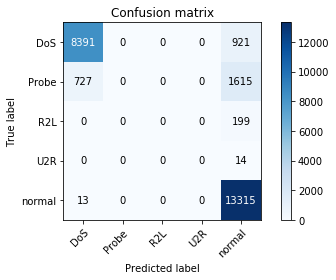

In [92]:
plot_confusion_matrix(cm=conf_matrix, classes=['DoS', 'Probe', 'R2L', 'U2R', 'normal'])

# Clustering
Some pointers:
- https://scikit-learn.org/stable/modules/clustering.html#k-means
- https://scikit-learn.org/stable/modules/clustering.html#dbscan

In [93]:
from sklearn import cluster

The maximum for each variable are highly different by orders of magnitude (from 0 to 10e9). We need to "normalize" (here divide by the max) to be compute more meaningful distances while clustering, and improve performance.

In [94]:
X_dummies.describe()

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,flag_REJ,flag_RSTO,flag_RSTOS0,flag_RSTR,flag_S0,flag_S1,flag_S2,flag_S3,flag_SF,flag_SH
count,100778.000000,1.007780e+05,1.007780e+05,100778.000000,100778.000000,100778.000000,100778.000000,100778.000000,100778.000000,100778.000000,...,100778.000000,100778.000000,100778.000000,100778.000000,100778.000000,100778.000000,100778.000000,100778.000000,100778.000000,100778.000000
mean,284.022736,4.411798e+04,2.410181e+04,0.000208,0.022862,0.000099,0.207297,0.001121,0.396555,0.293675,...,0.089037,0.012453,0.000804,0.018962,0.275487,0.002828,0.001022,0.000367,0.596529,0.002133
std,2579.010254,6.070337e+06,4.495814e+06,0.014434,0.254889,0.014087,2.168348,0.043062,0.489184,26.110153,...,0.284799,0.110897,0.028339,0.136393,0.446761,0.053104,0.031953,0.019158,0.490596,0.046140
min,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,4.400000e+01,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
75%,0.000000,2.750000e+02,5.250000e+02,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000
max,42908.000000,1.379964e+09,1.309937e+09,1.000000,3.000000,3.000000,77.000000,5.000000,1.000000,7479.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [95]:
# Normalization
X_normalized = X_dummies.apply(lambda x: (x * 1.0)/ x.max())
X_normalized_no_na = X_normalized.dropna(axis='columns')

In [96]:
X_normalized.describe()

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,flag_REJ,flag_RSTO,flag_RSTOS0,flag_RSTR,flag_S0,flag_S1,flag_S2,flag_S3,flag_SF,flag_SH
count,100778.000000,1.007780e+05,1.007780e+05,100778.000000,100778.000000,100778.000000,100778.000000,100778.000000,100778.000000,100778.000000,...,100778.000000,100778.000000,100778.000000,100778.000000,100778.000000,100778.000000,100778.000000,100778.000000,100778.000000,100778.000000
mean,0.006619,3.197039e-05,1.839921e-05,0.000208,0.007621,0.000033,0.002692,0.000224,0.396555,0.000039,...,0.089037,0.012453,0.000804,0.018962,0.275487,0.002828,0.001022,0.000367,0.596529,0.002133
std,0.060106,4.398910e-03,3.432083e-03,0.014434,0.084963,0.004696,0.028160,0.008612,0.489184,0.003491,...,0.284799,0.110897,0.028339,0.136393,0.446761,0.053104,0.031953,0.019158,0.490596,0.046140
min,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,3.188489e-08,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
75%,0.000000,1.992806e-07,4.007825e-07,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000
max,1.000000,1.000000e+00,1.000000e+00,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### K = 2

In [97]:
kmeans_normalized_k2 = cluster.KMeans(n_clusters=2, random_state=0).fit(X=X_normalized_no_na)
labels_k2 = y_train.copy()
labels_k2['cluster'] = kmeans_normalized_k2.labels_

In [98]:
labels_k2[:5]

,attack_type,cluster
119221,normal,0
10279,normal,0
32724,Probe,0
24281,normal,0
83777,DoS,1


In [99]:
labels.groupby(['attack_type', 'cluster']).size()

attack_type  cluster
DoS          1          27352
             2            768
             3           2989
             4           5506
Probe        0            149
             1            389
             2              4
             3           4643
             4           4129
R2L          0            749
             1              5
             2              3
             4             39
U2R          0             36
             3              2
normal       0          12061
             1             64
             2          28459
             3          11093
             4           2338
dtype: int64

In [100]:
labels.groupby(['cluster', 'attack_type']).size()

cluster  attack_type
0        Probe            149
         R2L              749
         U2R               36
         normal         12061
1        DoS            27352
         Probe            389
         R2L                5
         normal            64
2        DoS              768
         Probe              4
         R2L                3
         normal         28459
3        DoS             2989
         Probe           4643
         U2R                2
         normal         11093
4        DoS             5506
         Probe           4129
         R2L               39
         normal          2338
dtype: int64

### K = 3

In [101]:
kmeans_normalized_k3 = cluster.KMeans(n_clusters=3, random_state=0).fit(X=X_normalized_no_na)
labels_k3 = y_train.copy()
labels_k3['cluster'] = kmeans_normalized_k3.labels_

In [102]:
labels_k3.groupby(['cluster', 'attack_type']).size()

cluster  attack_type
0        DoS            27352
         Probe            390
         R2L                6
         normal            98
1        DoS             3757
         Probe           4771
         R2L              751
         U2R               38
         normal         51560
2        DoS             5506
         Probe           4153
         R2L               39
         normal          2357
dtype: int64

### K = 5

In [103]:
kmeans_normalized_k5 = cluster.KMeans(n_clusters=5, random_state=0).fit(X=X_normalized_no_na)
labels_k5 = y_train.copy()
labels_k5['cluster'] = kmeans_normalized_k5.labels_

In [104]:
labels_k5.groupby(['cluster', 'attack_type']).size()

cluster  attack_type
0        Probe            149
         R2L              749
         U2R               36
         normal         12061
1        DoS            27352
         Probe            389
         R2L                5
         normal            64
2        DoS              768
         Probe              4
         R2L                3
         normal         28459
3        DoS             2989
         Probe           4643
         U2R                2
         normal         11093
4        DoS             5506
         Probe           4129
         R2L               39
         normal          2338
dtype: int64

### Quelques resultats et visualisations
comparaison kmeans et local density clustering: http://yinsenm.github.io/2014/08/18/kdd99-cluster/

# Mesure de performance - classification
Essayez d'obtenir:
- silhouette
- homogénéité

*doc: https://scikit-learn.org/stable/modules/clustering.html#clustering-performance-evaluation*

The best value is 1 and the worst value is -1. Values near 0 indicate overlapping clusters. Negative values generally indicate that a sample has been assigned to the wrong cluster, as a different cluster is more similar.

In [ ]:
# k=2 (run this after using k=2 when clustering)
metrics.silhouette_score(X=X_normalized_no_na,
                         labels=kmeans_normalized_k2.labels_,
                         metric='manhattan')

In [ ]:
# k=3 (run this after using k=3 when clustering)
metrics.silhouette_score(X=X_normalized_no_na,
                         labels=kmeans_normalized_k3.labels_,
                         metric='manhattan')

### PCA + vrais labels
classes = ['normal', 'Probe', 'DoS', 'R2L', 'U2R']

In [83]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca_result = pca.fit_transform(X_normalized_no_na.values)

print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))

Explained variation per principal component: [0.41213243 0.15632861]


In [35]:
y_catcode = y_train.copy()
y_catcode.attack_type = pd.Categorical(y_catcode.attack_type)
y_catcode.attack_type = y_catcode.attack_type.cat.codes

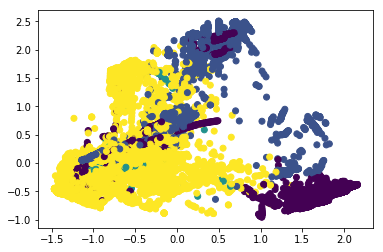

In [36]:
plt.scatter(pca_result[:,0], pca_result[:,1], c=y_catcode.attack_type)

### PCA + vrais labels binarisés (normal vs attaque)
classes = ['normal', 'attaque']

In [87]:
y_bincode = y_train.copy()
y_bincode.attack_type = y_bincode.attack_type.map(lambda x: x=='normal')
y_bincode.attack_type = pd.Categorical(y_bincode.attack_type)
y_bincode.attack_type = y_bincode.attack_type.cat.codes

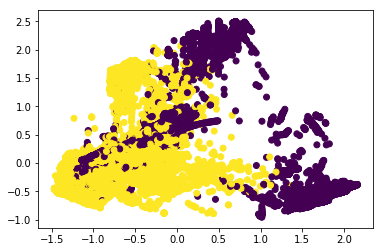

In [88]:
plt.scatter(pca_result[:,0], pca_result[:,1], c=y_bincode.attack_type)

### PCA + labels des K-means
**Rappel**: les couleurs ne veulent rien dire, elles representent les numéros de clusters (0, 1, ...) qui eux-mêmes n'ont pas de signification particulière.

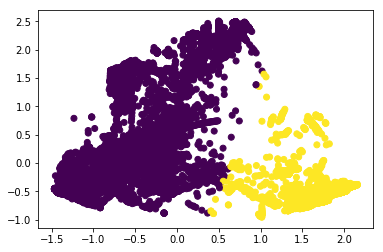

In [66]:
# k=2
k_means_catcode = kmeans_normalized_k2.labels_.copy()
plt.scatter(pca_result[:,0], pca_result[:,1], c=k_means_catcode)

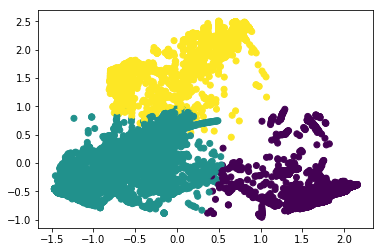

In [61]:
# k=3
k_means_catcode = kmeans_normalized_k3.labels_.copy()
plt.scatter(pca_result[:,0], pca_result[:,1], c=k_means_catcode)

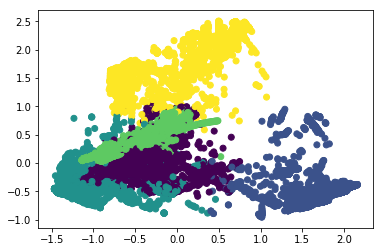

In [68]:
# k=5
k_means_catcode = kmeans_normalized_k5.labels_.copy()
plt.scatter(pca_result[:,0], pca_result[:,1], c=k_means_catcode)

### Labels K-means par rapport aux vrais labels

In [182]:
def plot_clusters_with_classes(cluster_df, k):
    # Zero for classes not represented in a cluster
    for cluster_id in range(k):
        for attack in ['DoS', 'Probe', 'R2L', 'U2R', 'normal']:
            if attack not in cluster_df.loc[cluster_id]:
                cluster_df.loc[cluster_id, attack] = 0

    fig, ax = plt.subplots(1, k, figsize=(k*4, 4))
    for i in range(k):
        ax[i].bar(x=cluster_df[i].index, height=cluster_df[i])
        ax[i].set_title('cluster {}'.format(i))
        ax[i].set_ylim([0,55000])
    plt.show()

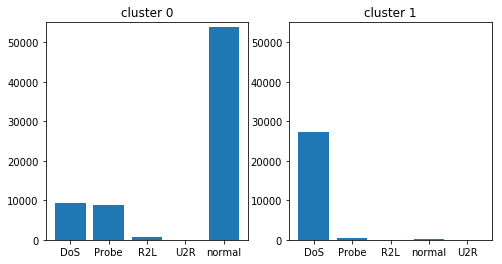

In [185]:
# k=2
plot_clusters_with_classes(cluster_df=labels_k2.groupby(['cluster', 'attack_type']).size(), k=2)

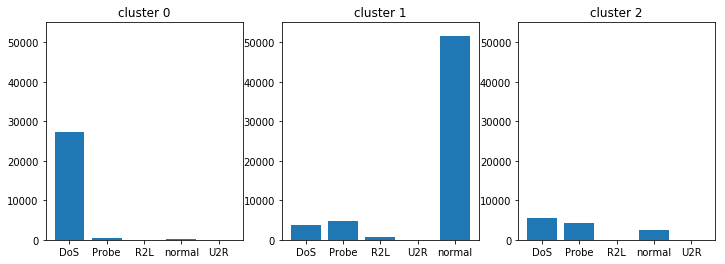

In [183]:
# k=3
plot_clusters_with_classes(cluster_df=labels_k3.groupby(['cluster', 'attack_type']).size(), k=3)

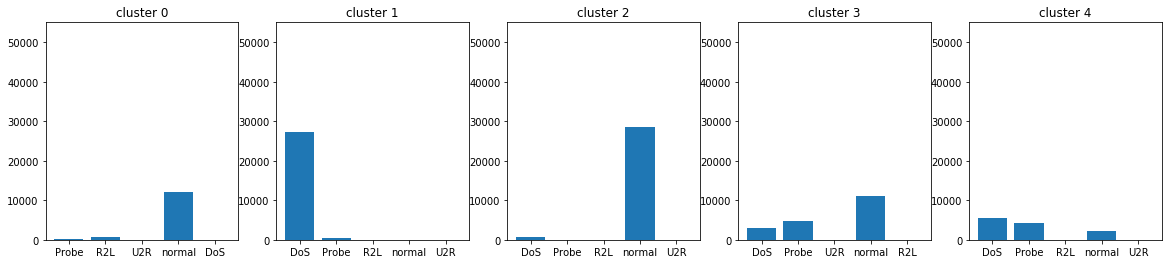

In [184]:
# k=5
plot_clusters_with_classes(cluster_df=labels_k5.groupby(['cluster', 'attack_type']).size(), k=5)